In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import folium

In [2]:
DATA_PATH = 'data/'

raw = pd.read_csv(DATA_PATH+'uber-raw-data-janjune-15.csv',parse_dates=['Pickup_date'])

In [3]:
interval = 5 #minutes
future = 7
raw['Pickup_date']=(raw['Pickup_date'] - np.min(raw['Pickup_date'])).astype(np.int64)//((10e+8)*interval*60)

In [4]:
grouped = raw.groupby(by=[raw.Pickup_date,raw.locationID])
x = pd.DataFrame(grouped.size())
x.reset_index(inplace=True)
x = x.pivot(index='Pickup_date', columns='locationID',values=0).fillna(0)

In [5]:
#not all 5min intervals between jan and june are included in the database
missing = set(np.arange(np.max(x.index.values)+1))-set(x.index.values) 

In [6]:
x.index = x.index.astype(int)
x.head()

locationID,1,2,3,4,5,6,7,8,9,10,...,256,257,258,259,260,261,262,263,264,265
Pickup_date,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,...,7.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0
1,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,1.0,0.0,...,8.0,1.0,1.0,0.0,1.0,1.0,5.0,4.0,0.0,0.0
2,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,0.0,0.0
3,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,...,7.0,1.0,0.0,0.0,4.0,0.0,7.0,5.0,0.0,0.0
4,0.0,0.0,0.0,7.0,0.0,0.0,9.0,0.0,0.0,0.0,...,6.0,0.0,0.0,1.0,0.0,3.0,4.0,10.0,0.0,1.0


Text(0.5, 1.0, '2 week traffic variation')

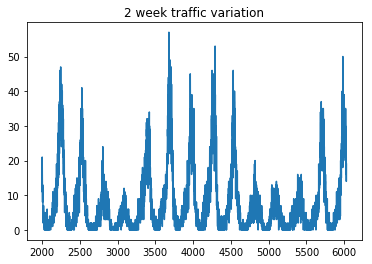

In [7]:
plt.plot(x[161][2000:6032])
plt.title('2 week traffic variation')

## Graph dependant data generation

In [8]:
sparsed = pd.read_csv(DATA_PATH+'sparsedDist.csv',index_col=0)

In [9]:
G = nx.from_numpy_matrix(sparsed.values)
assert nx.is_connected(G)
#number of edges
print('Nodes: {} , Edges: {}'.format(len(G),len(G.edges())))

Nodes: 250 , Edges: 6997


In [10]:
drop_cols = list(set(x.columns.values) - set(sparsed.columns.values.astype(int)))
x = x.drop(drop_cols,axis=1)

## Split train/label

This split is done to train the complex models such as recurrent nets, time convolutional nets, the TV-GCNN etc... The regression model will be split in another manner.

First, we will calculate quick approximations to see how much non-overlapping data we can obtain. We may be able to generate more by adding gaussian noise to data samples.

In [11]:
timesteps = len(x)
len_seq = 12+7 #training, testing 
#--> important to note that 19*5 is 1h35 so samples desync from a day's and week's time for diversity

timesteps/len_seq

2737.157894736842

In [12]:
def split_seq(seq,size):
    """ Split up seq in pieces of size """
    for i in range(0,len(seq),size):
        if i+size<len(seq) and seq[i+size] - seq[i] == size:
            yield seq[i:i+size]

In [13]:
seqs = np.array(list(split_seq(x.index.values,19)))
np.random.shuffle(seqs)
print('{} total samples'.format(len(seqs)))

2734 total samples


In [14]:
#example of a sample input+labelsx
x.loc[seqs[2]]

locationID,3,4,6,7,8,9,10,11,12,13,...,254,255,256,257,258,259,260,261,262,263
Pickup_date,,,,,,,,,,,,,,,,,,,,,
42207,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,3.0
42208,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,...,1.0,3.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0
42209,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
42210,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
42211,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,...,0.0,4.0,2.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0
42212,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,...,0.0,2.0,1.0,1.0,0.0,0.0,2.0,3.0,1.0,1.0
42213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0
42214,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
42215,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0


In [15]:
x

locationID,3,4,6,7,8,9,10,11,12,13,...,254,255,256,257,258,259,260,261,262,263
Pickup_date,,,,,,,,,,,,,,,,,,,,,
0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,6.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0
1,0.0,5.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,3.0,...,0.0,9.0,8.0,1.0,1.0,0.0,1.0,1.0,5.0,4.0
2,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,11.0,8.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0
3,0.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,2.0,7.0,1.0,0.0,0.0,4.0,0.0,7.0,5.0
4,0.0,7.0,0.0,9.0,0.0,0.0,0.0,2.0,0.0,8.0,...,0.0,5.0,6.0,0.0,0.0,1.0,0.0,3.0,4.0,10.0
5,0.0,6.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,8.0,6.0,0.0,0.0,0.0,0.0,3.0,2.0,6.0
6,0.0,4.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,4.0,...,0.0,8.0,5.0,1.0,0.0,0.0,0.0,0.0,4.0,7.0
7,0.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,10.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,11.0
8,0.0,6.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,5.0,...,0.0,15.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0


## Baseline models

### Naive Regression model (poor case performance)

We will input all training data in a regression model and see how it fares.

We have to note that this is not exactly what is intended for the end, as the model has access to "future data" in the training.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse

In [22]:
ratio = 0.8
split = int(len(seqs)*ratio)
train_steps,test_steps = [],[]
train_steps = sum(list(train_steps +list(seqs[i]) for i in range(split)),[])
test_steps  = sum(list(test_steps +list(seqs[i]) for i in range(split,len(seqs))),[])
assert len(train_steps) == 19*split

In [18]:
trainY = x.loc[train_steps][234].values
testY =  x.loc[test_steps][234].values

In [19]:
X = np.array(train_steps).reshape(-1, 1)
Y = trainY

poly = PolynomialFeatures(degree=4)
X_ = poly.fit_transform(X)

#clf = linear_model.LinearRegression()
clf = linear_model.Ridge(alpha=0.1)
clf.fit(X_, Y)

/home/manu/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.13677e-36): result may not be accurate.
  overwrite_a=True).T


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [20]:
predict= np.array(test_steps).reshape(-1, 1)
predict_ = poly.fit_transform(predict)
y_pred = clf.predict(predict_)

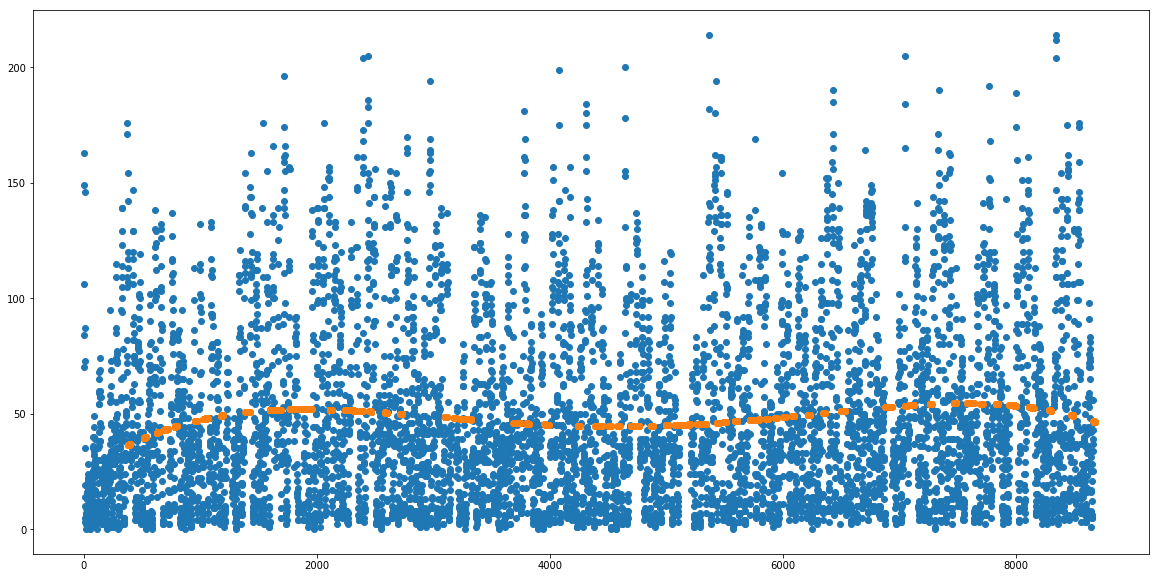

In [21]:
plt.figure(figsize=(20,10))
plt.scatter(X,Y)
plt.scatter(predict,y_pred)

In [22]:
mse(testY, y_pred)

1570.312350168433

Let's calculate the average MSE per node, since this is poor case performance we won't bother with polynomial models that don't even improve the model much.

In [23]:
errors = []
for col in x.columns.values:
    trainY = x.loc[train_steps][col].values
    testY =  x.loc[test_steps][col].values

    X = np.array(train_steps).reshape(-1, 1)
    Y = trainY

    #clf = linear_model.LinearRegression()
    clf = linear_model.Ridge(alpha=1.0)
    clf.fit(X, Y)

    predict= np.array(test_steps).reshape(-1, 1)
    y_pred = clf.predict(predict)
    errors.append(mse(testY, y_pred))
    
print('Mean error is {} '.format(np.mean(errors)))

Mean error is 95.08257903879068 


Text(0.5, 1.0, 'Nodewise MSE for a simple linear regression model')

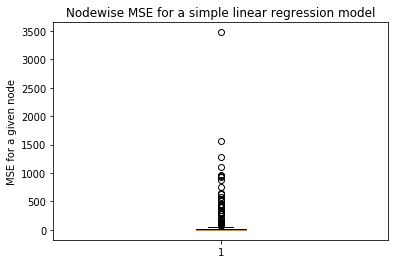

In [24]:
plt.boxplot(errors);
plt.ylabel('MSE for a given node')
plt.title('Nodewise MSE for a simple linear regression model')

It is interesting to note that the MSE is much worse for highly frequented nodes. A lot of nodes just don't have much uber rides so a mean value close to 0 all the time is actually a good estimation.

## LSTM model baseline

We will try to improve the regression baseline with vanilla LSTM models built in PyTorch.

In [16]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler, StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu");

In [17]:
# normalize data
# adapt model to our problem
# metrics

In [18]:
#dataloader
#minmax scaler
#https://pytorch.org/docs/stable/optim.html

In [19]:
class DataLoader(data.Dataset):
    def __init__(self,graph_data,randList,transform=None,train_num=12):
        self.graph_data = graph_data
        self.length = len(randList)
        self.randList = randList
        self.transform = transform
        self.train_num = train_num
    
    def __len__(self):
        return self.length
        
    def __getitem__(self,index):

        x = self.graph_data.loc[seqs[index]][:self.train_num]
        targets = self.graph_data.loc[seqs[index]][self.train_num:]

        
        x = torch.tensor(x.values)
        targets = torch.tensor(targets.values)

        if self.transform:
            x = self.transform.transform(x)
            targets = self.transform.transform(targets)
            
        #permutations ?
            
        sample = {'x': x,'targets':targets}

        return sample

In [20]:
class DataLoaderSpecific(data.Dataset):
    def __init__(self,graph_data,randList,transform=None,train_num=12,test_num = 1):
        self.graph_data = graph_data
        self.length = len(randList)
        self.randList = randList
        self.transform = transform
        self.train_num = train_num
        self.test_num = test_num
    
    def __len__(self):
        return self.length
        
    def __getitem__(self,index):

        x = self.graph_data.loc[seqs[index]][:self.train_num]
        targets = self.graph_data.loc[seqs[index]][self.train_num:self.train_num+self.test_num]
        #one time step for now
        

        
        x = torch.tensor(x.values).reshape(-1, 1)
        targets = torch.tensor(targets.values).reshape(-1, 1)

        if self.transform:
            x = self.transform.transform(x.reshape(-1, 1))
            targets = self.transform.transform(targets.reshape(-1, 1))
                        
        #permutations ?
            
        sample = {'x': x,'targets':targets}

        return sample

In [30]:
ratio = 0.8
split = int(len(seqs)*ratio)

In [31]:
#global
#scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()
scaler.fit(x)

scaler = None
x2 = (x - x.mean())/x.std()

train_ds = DataLoader(x2,seqs[:split],transform = scaler)
train_dl = data.DataLoader(train_ds,batch_size = 10,shuffle=True,num_workers = 4)

In [32]:
x.sum()

locationID
3        3684.0
4       89319.0
6         662.0
7       90870.0
8         369.0
9        3040.0
10       6812.0
11       3559.0
12       2579.0
13     139993.0
14      35927.0
15       3229.0
16       8880.0
17      80312.0
18       6579.0
19       3026.0
20       9153.0
21       8409.0
22      10456.0
23        925.0
24      23717.0
25      69154.0
26      15760.0
27        114.0
28      11901.0
29       4434.0
31       2299.0
32       4031.0
33      77788.0
34      10294.0
         ...   
234    419045.0
235      6154.0
236    229344.0
237    284514.0
238    133828.0
239    185741.0
240      1416.0
241      8430.0
242      7261.0
243     35881.0
244     49303.0
245       435.0
246    279100.0
247     13381.0
248      3605.0
249    323989.0
250      4360.0
251       634.0
252      5199.0
253       815.0
254      4979.0
255    217938.0
256    141357.0
257     21460.0
258     10059.0
259      3588.0
260     20369.0
261     67904.0
262    108338.0
263    133630.0
Length: 250, 

In [33]:
#node specific
#node = 28
node = 4

#scaler = MinMaxScaler(feature_range=(-1, 1))
#x = (x-x.mean(axis=0))/x.std(axis=0)

scaler = StandardScaler()
scaler.fit(x[node].values.reshape(-1, 1))

scaler = None
x2 = (x - x.mean())/x.std()


train_ds = DataLoaderSpecific(x2[node],seqs[:split],transform = scaler, test_num = future)
train_dl = data.DataLoader(train_ds,batch_size = 25,shuffle=True,num_workers = 4)

test_ds = DataLoaderSpecific(x2[node],seqs[split:],transform = scaler,test_num = future)
test_dl = data.DataLoader(test_ds,batch_size = 50,shuffle=False,num_workers = 4)

In [34]:
for sample in train_dl:
    break
print(sample['x'].shape)
print(sample['targets'].shape)

torch.Size([25, 12, 1])
torch.Size([25, 7, 1])


Baselines will first be executed with respect to only a single node.

## Model definition

In [35]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]

        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [36]:
seq = Sequence()
seq.double()
criterion = nn.MSELoss(reduction='sum')

optimizer = torch.optim.Adam(seq.parameters(), lr = 10e-4)

In [37]:
import warnings
warnings.filterwarnings("ignore")

#begin to train
for e in range(25):
     
    seq.train()   
    train_loss = 0
    
    for sample in train_dl:
        
       
        
        inputs = sample['x'].squeeze(2).to(device)
        targets = sample['targets'].squeeze(2).to(device)
        #print(inputs.shape)

        
        optimizer.zero_grad()
        out = seq(inputs,future=future)
        
        loss = criterion(out[:,-future:], targets)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        
        
    
    print('Loss for epoch {} ---> {}'.format(e,train_loss/train_ds.__len__()))
    
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        test_loss = 0
        test_loss2 = 0
        seq.eval()


        for sample in test_dl:
            
            test_inputs = sample['x'].squeeze(2).to(device)
            test_targets = sample['targets'].squeeze(2).to(device)
            
            pred = seq(test_inputs, future=future)
            #print(test_targets.view(1,-1).shape)
            #print(pred[:, -future:].shape)
            #print(test_targets.shape)
            test_loss += criterion(pred[:, -future:], test_targets).item()            
            
        print('\t\t - Test loss:', test_loss/(test_ds.__len__()*future))     

Loss for epoch 0 ---> 6.9325293833561314
		 - Test loss: 1.0378917901654623
Loss for epoch 1 ---> 6.56783458463084
		 - Test loss: 0.8865788528978823
Loss for epoch 2 ---> 6.096180295925954
		 - Test loss: 0.8178910757856337
Loss for epoch 3 ---> 5.705457085271268
		 - Test loss: 0.800301247850522
Loss for epoch 4 ---> 5.4401212962316725
		 - Test loss: 0.7212903962938838
Loss for epoch 5 ---> 5.0665107923277315
		 - Test loss: 0.7214930609897668
Loss for epoch 6 ---> 5.0547390845750835
		 - Test loss: 0.634690917184368
Loss for epoch 7 ---> 4.663382707861356
		 - Test loss: 0.671558868106464
Loss for epoch 8 ---> 4.543859733607411
		 - Test loss: 0.6149897845383642
Loss for epoch 9 ---> 4.467600481867754
		 - Test loss: 0.6084792360091699
Loss for epoch 10 ---> 4.404401824683619
		 - Test loss: 0.6015100831049103
Loss for epoch 11 ---> 4.4806676383754365
		 - Test loss: 0.6676616530728788
Loss for epoch 12 ---> 4.59406223800287
		 - Test loss: 0.6405251394853249
Loss for epoch 13 --->

In [38]:
def fit_regression(x,target):
    
    clf = linear_model.LinearRegression()
    #clf = linear_model.Ridge(alpha=0.1)
    clf.fit(np.arange(len(x)).reshape(-1, 1), x)
    pred = clf.predict(np.arange(12,12+future).reshape(-1, 1))
    
    msError = mse(pred, target)

    return pred, msError

In [39]:
test_loss1 = 0
test_loss2 = 0

seq.eval()

for sample in test_dl:

    test_inputs = sample['x'].squeeze(2).to(device)
    test_targets = sample['targets'].squeeze(2).to(device)
    
    
    pred1 = seq(test_inputs, future=future)
    test_loss1 += criterion(pred1[:, -future:], test_targets).item()           
    
    pred2 = np.zeros(pred1[:, -future:].shape)

    for i in range(len(test_inputs)):
        inputs = np.array(test_inputs[i])
        target = np.array(test_targets[i])
        

        pred2[i], msError = fit_regression(inputs,target)
        test_loss2 += msError
        
            

print('\t LSTM Test loss:', test_loss1/(test_ds.__len__()*future))
print('\t Linear Regression Test loss:', test_loss2/(test_ds.__len__()))

	 LSTM Test loss: 0.5060255841202687
	 Linear Regression Test loss: 1.9532212468691708


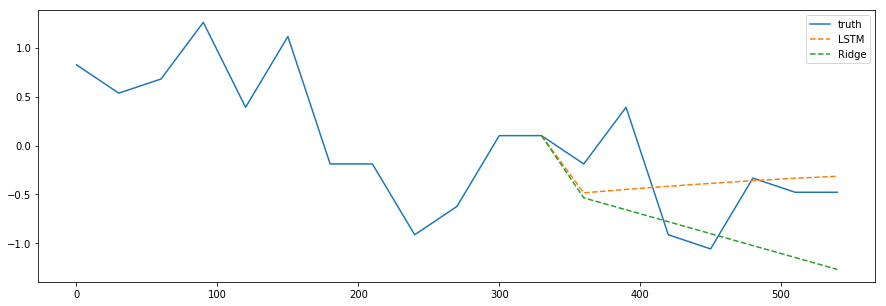

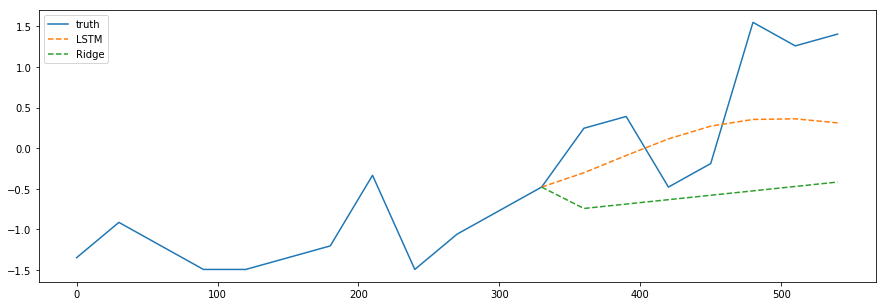

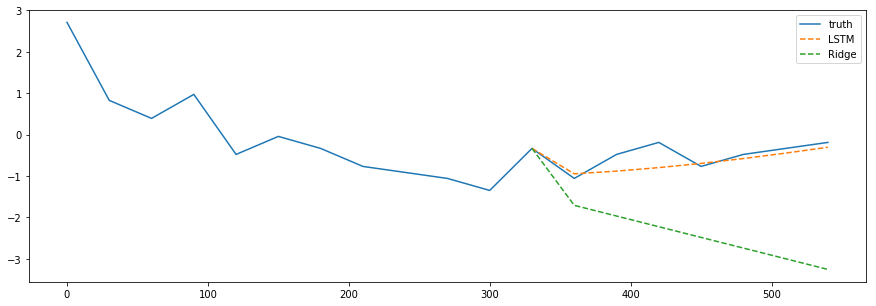

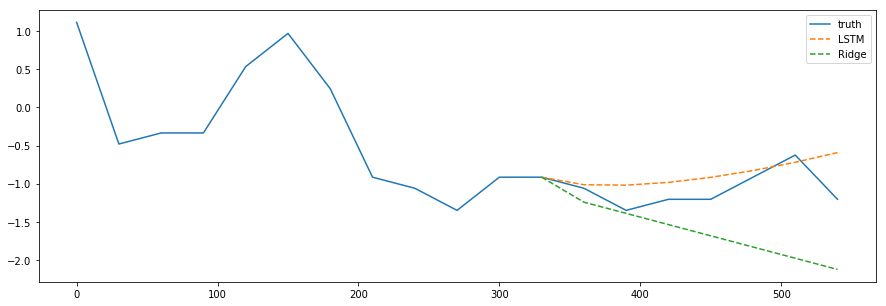

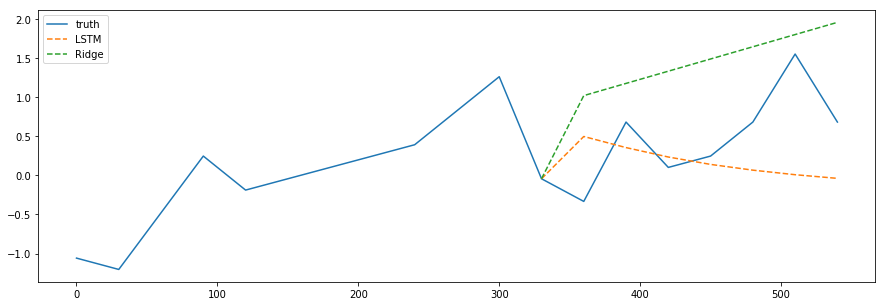

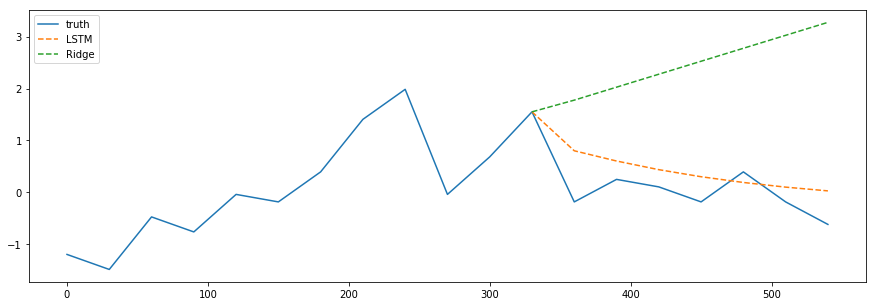

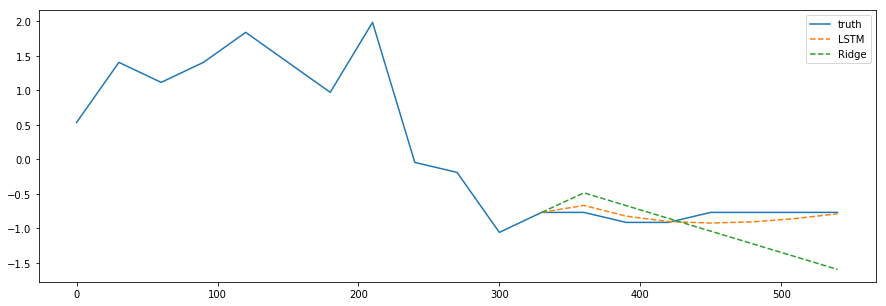

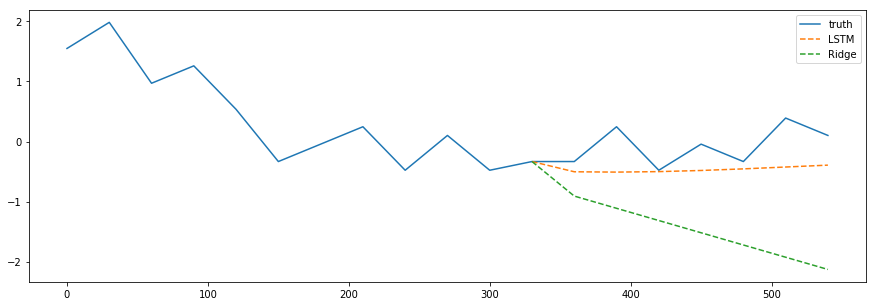

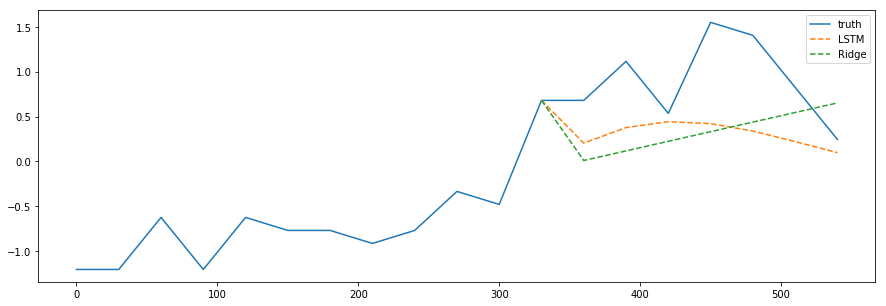

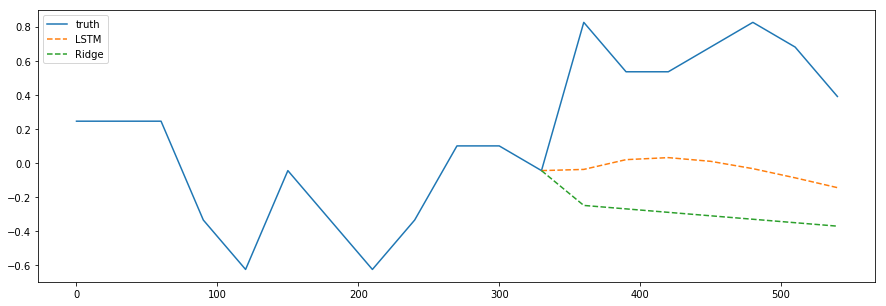

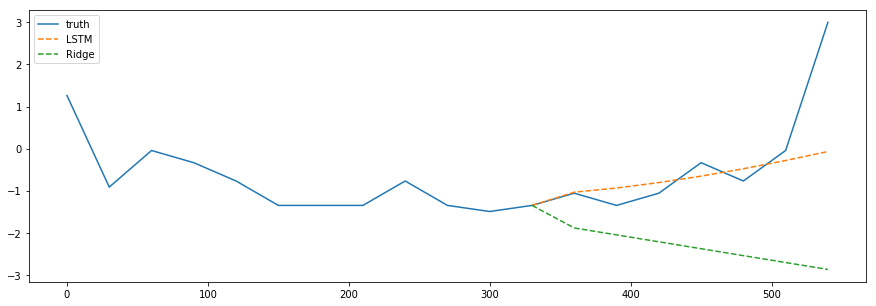

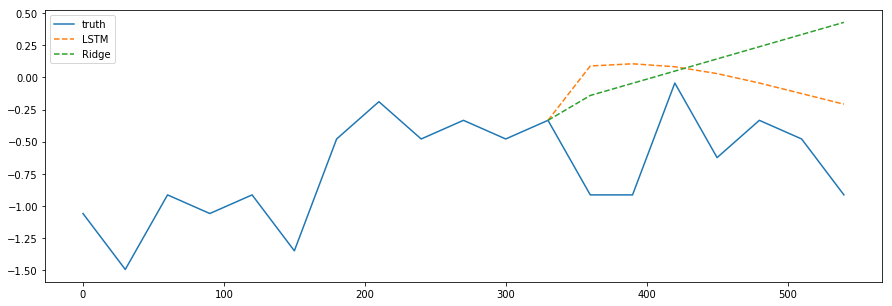

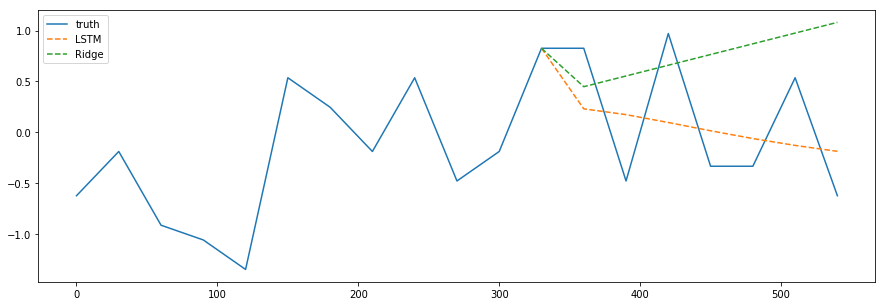

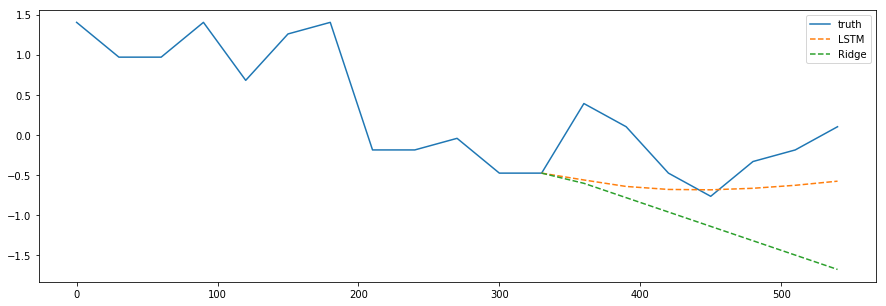

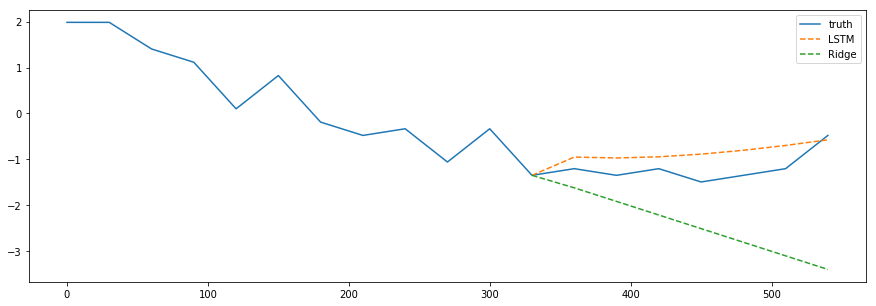

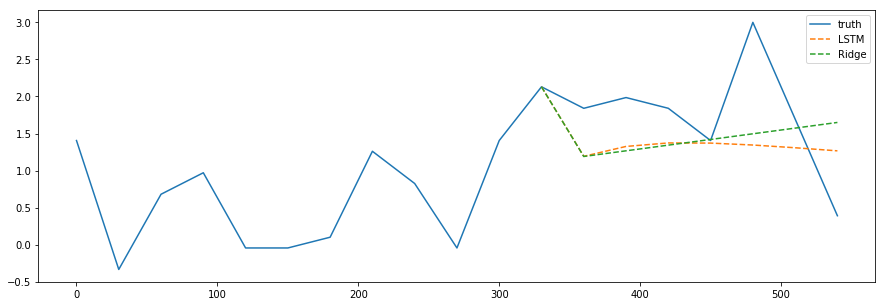

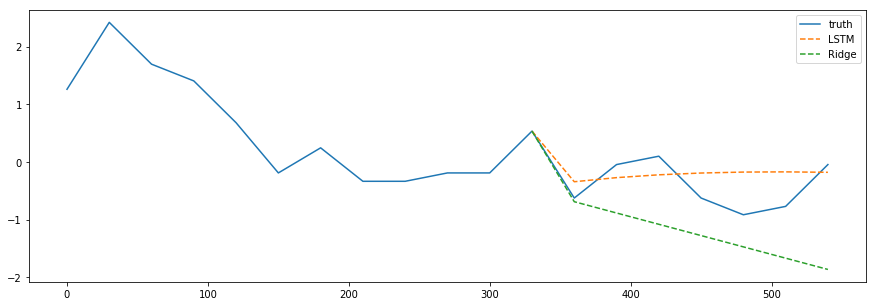

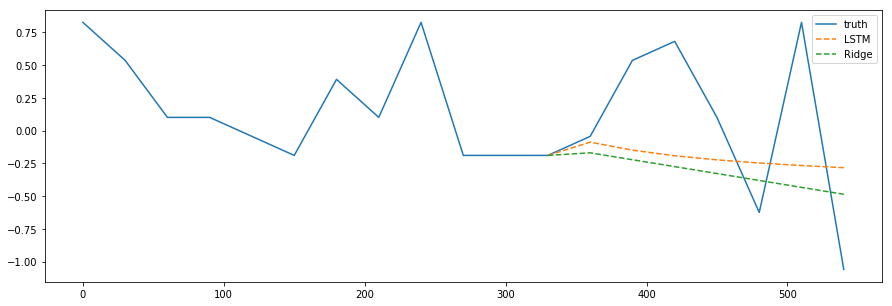

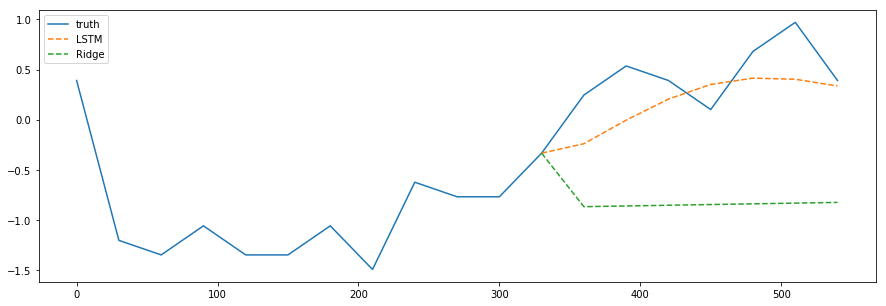

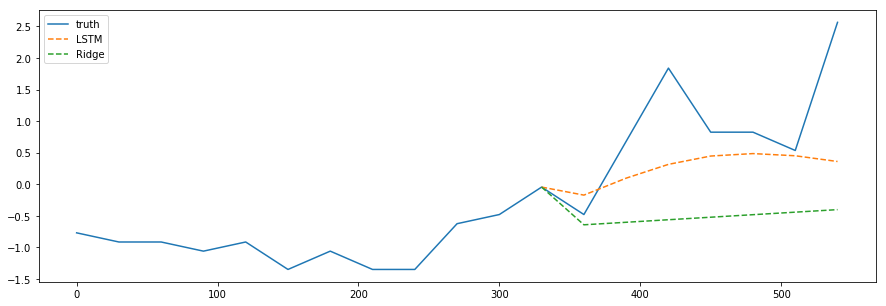

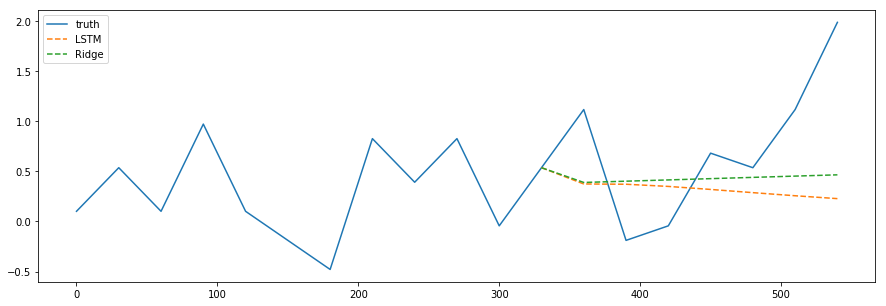

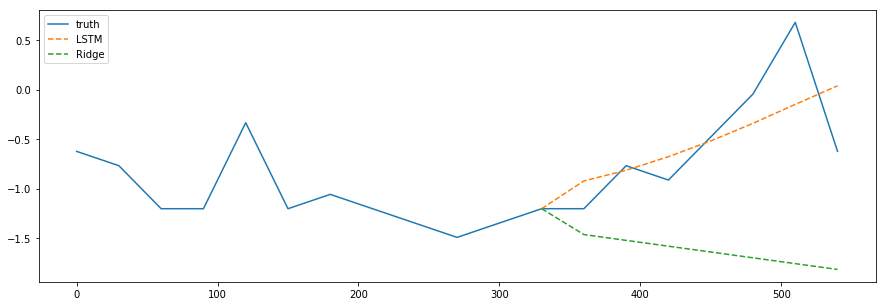

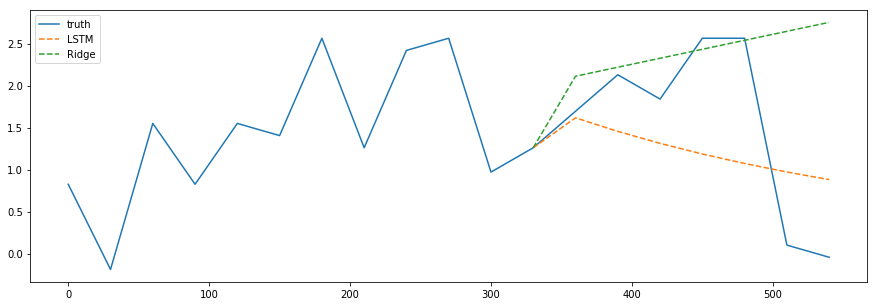

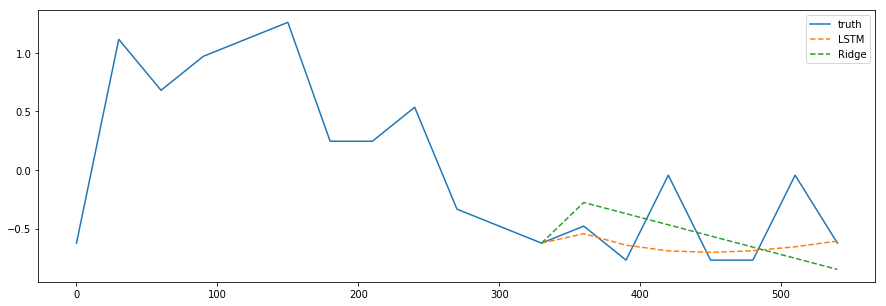

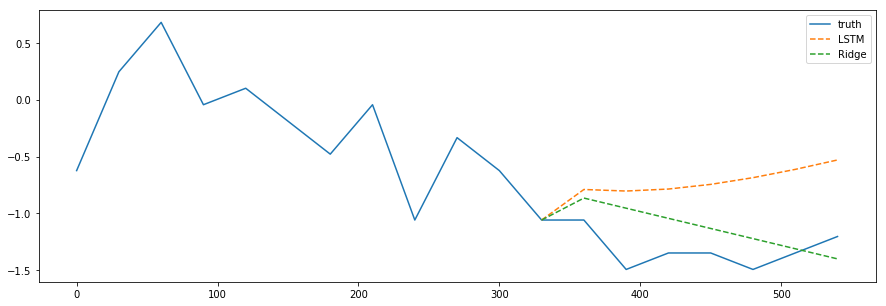

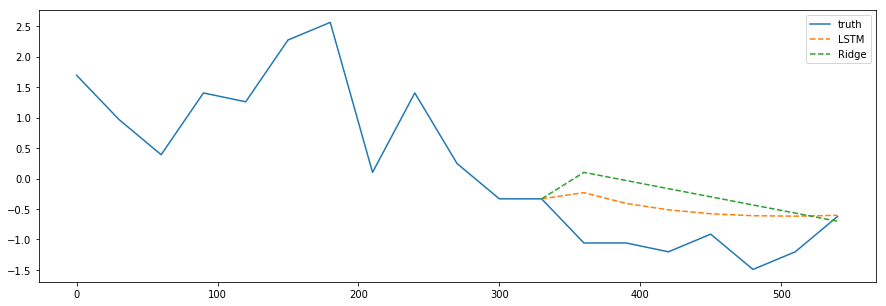

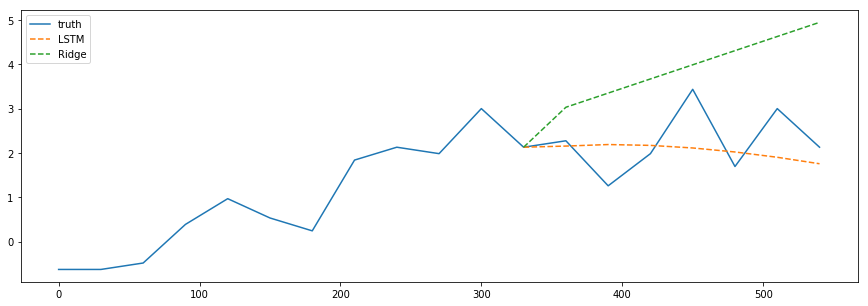

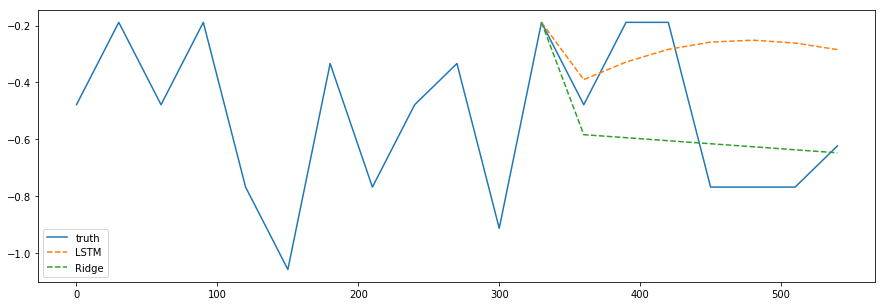

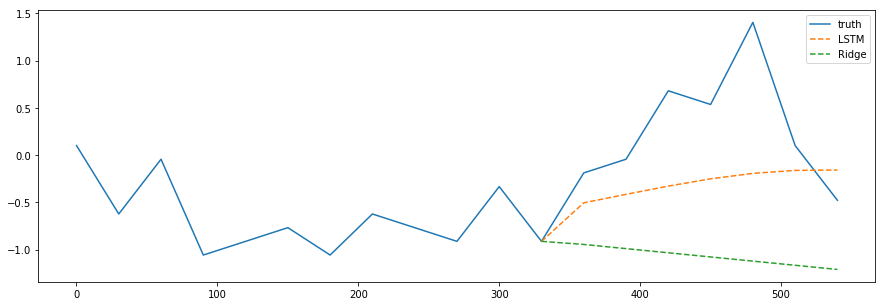

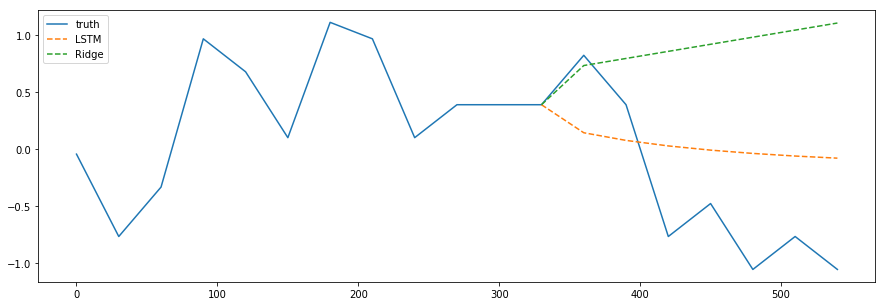

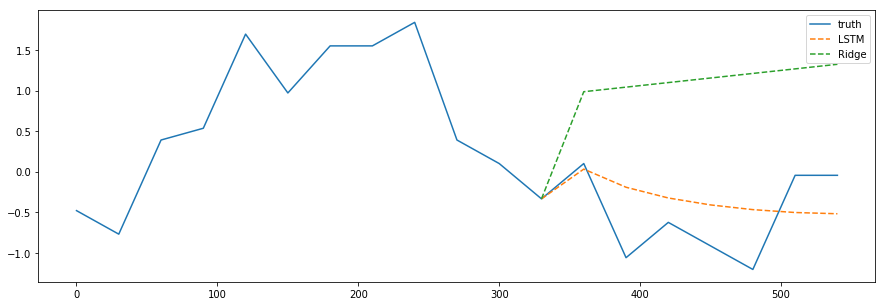

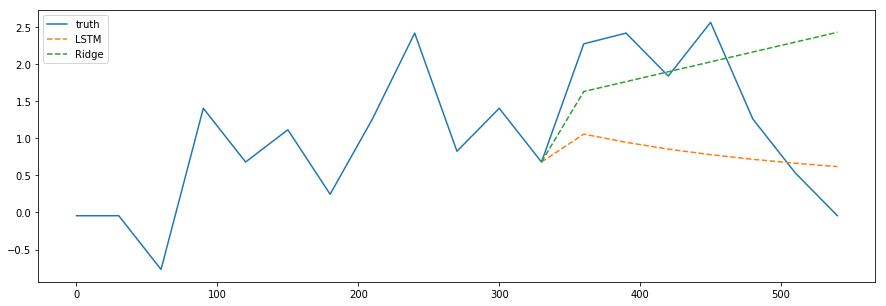

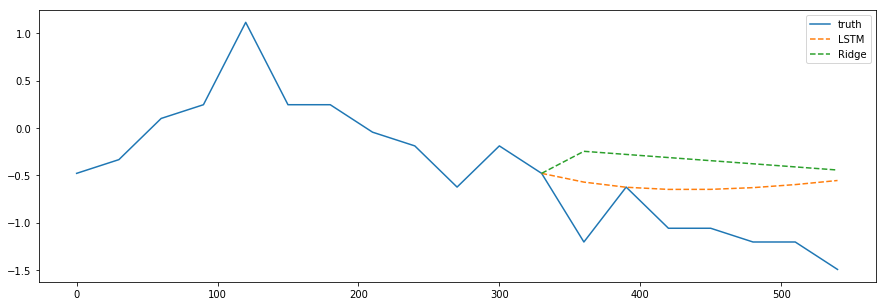

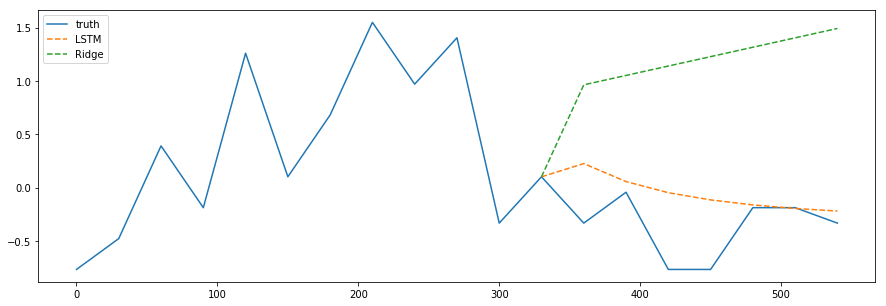

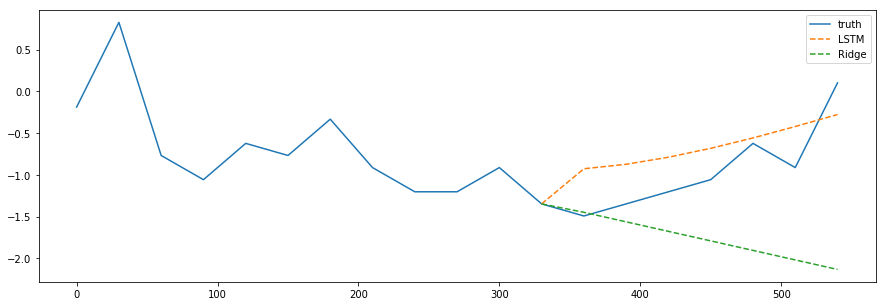

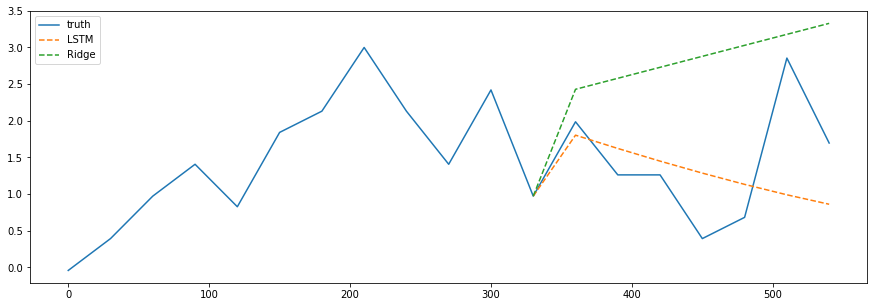

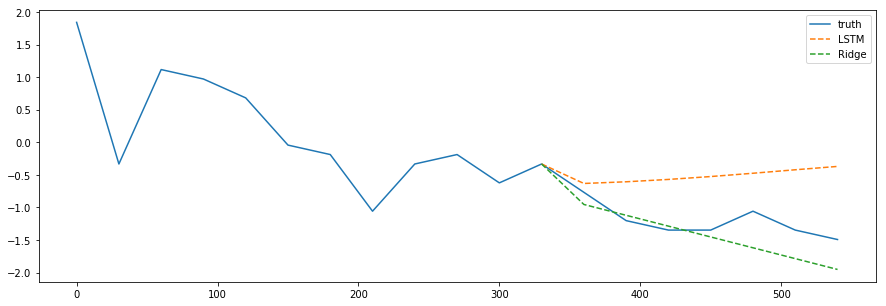

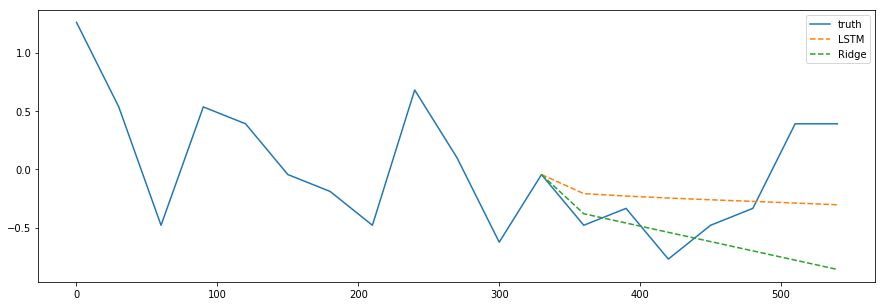

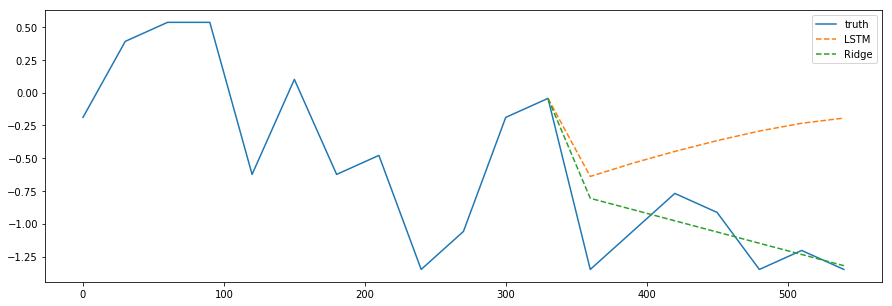

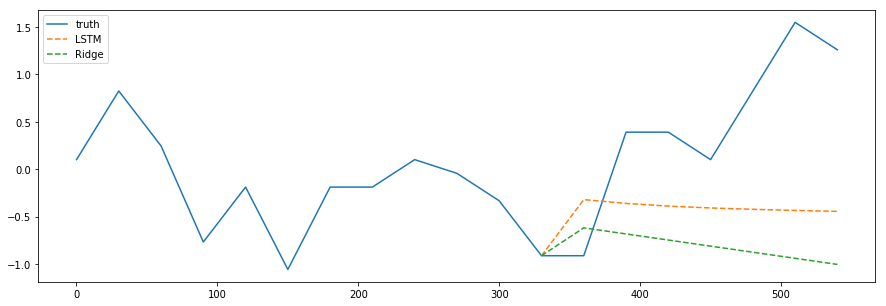

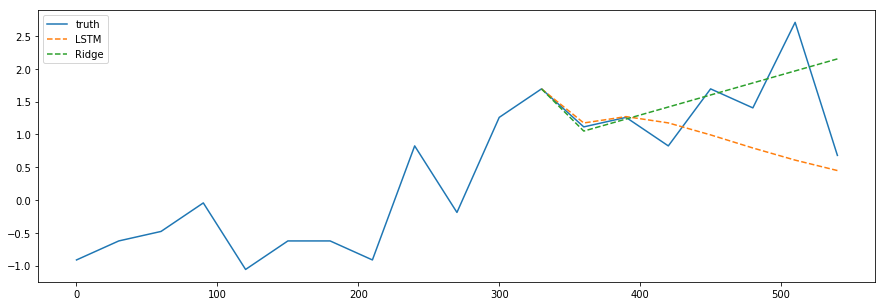

In [40]:
for i in range(0,len(test_inputs)):
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(12+future)*interval,np.array(list(test_inputs[i])+list(test_targets[i])),label = 'truth')
    
    plt.plot(np.arange(11,12+future)*interval,np.array(list(test_inputs[i][-1:])+list(pred1[:, -future:][i])),linestyle='dashed',label = 'LSTM')
    plt.plot(np.arange(11,12+future)*interval,np.array(list(test_inputs[i][-1:])+list(pred2[i])),linestyle='dashed',label = 'Ridge')
    
    plt.legend()

## Initial Conclusions

The basic baseline models that were implemented show possible but limited predictive capabilities. It is interesting to note that the LSTM models better capture long-term trends and perform better in less noisy experiments (bigger time intervals to smooth out the noise, longer periods), while regression models fare better during short and noisy experiments.

The goal of the TV-GCNN will be to have predictive capacities that hopefully go beyond simple regression models while leveraging spatial data from neighboring node to decrease the noisiness of local data.


## Time convolution networks

Doesn't work here, maybe there is a problem ?

In [26]:
import torch.nn.functional as F

In [42]:
class TConv(nn.Module):
    def __init__(self):
        super(TConv, self).__init__()
        self.conv1 = nn.Conv1d(1,20,kernel_size=3, stride=1)   #slides
        self.conv2 = nn.Conv1d(20, 40, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(40*3, 20)
        self.fc2 = nn.Linear(20,1)
        self.pool = nn.MaxPool1d(2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x)))
        #print(x.shape)
        x = F.relu(self.fc1(x.view(-1, 40*3)))
        x = self.fc2(x.view(-1, 20))
        return x
    

In [24]:
class TConvDilated(nn.Module):
    def __init__(self):
        super(TConvDilated, self).__init__()
        #for 12 input size
        self.conv1 = nn.Conv1d(1 , 10, kernel_size=2, stride=1,dilation=1)   #slides
        self.conv2 = nn.Conv1d(10, 20, kernel_size=2, stride=1,dilation=2)
        self.conv3 = nn.Conv1d(20, 40, kernel_size=3, stride=1,dilation=4)
        #self.fc1 = nn.Linear(40, 20)
        self.fc2 = nn.Linear(40,1)

    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        #print(x.shape)
        #x = F.relu(self.fc1(x.view(-1, 40*3)))
        x = self.fc2(x.view(-1, 40))
        return x

In [175]:
tconv = TConvDilated()
tconv.double()
criterion = nn.MSELoss(reduction='sum')

optimizer = torch.optim.Adam(tconv.parameters(), lr = 10e-4)

In [176]:
tconv.train()   
test_loss = 0

for e in range(30):
     
    train_loss = 0
    
    for sample in train_dl:
        
       
        
        inputs = sample['x'].squeeze(2).to(device)
        targets = sample['targets'].squeeze(2)[:,0].to(device)
        
        
        optimizer.zero_grad()
        out = tconv(inputs.unsqueeze(1))
        

        loss = criterion(out, targets.unsqueeze(1))
        
        #print(loss.item())
        
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        
    print('Loss for epoch {} ---> {}'.format(e,train_loss/train_ds.__len__()))
   
    

    with torch.no_grad():
        
        tconv.eval()
        test_loss = 0
        
        for sample in test_dl:

            test_inputs = sample['x'].squeeze(2).to(device)
            #test_targets = sample['targets'].squeeze(2)[:,0].to(device)

            #out = tconv(test_inputs.unsqueeze(1))
            
            test_targets = sample['targets'].squeeze(2).to(device)
            pred = test_inputs.unsqueeze(1)
            for _ in range(7):
                pred = torch.cat((pred, tconv(pred).unsqueeze(2)),2)[:,:,-12:]
                
                

            loss = criterion(pred[:,:,-future:], test_targets.unsqueeze(1))


            test_loss += loss.item()

        print('\t Dilated Time convolution Test loss:', test_loss/(test_ds.__len__()*future))
    
    tconv.train()


Loss for epoch 0 ---> 0.8585980014755284
	 Dilated Time convolution Test loss: 0.8707780649044282
Loss for epoch 1 ---> 0.7141235247089734
	 Dilated Time convolution Test loss: 0.7481770626753317
Loss for epoch 2 ---> 0.6097882362086994
	 Dilated Time convolution Test loss: 0.6550213401682728
Loss for epoch 3 ---> 0.5455924562197559
	 Dilated Time convolution Test loss: 0.6336763014349582
Loss for epoch 4 ---> 0.5400939025895574
	 Dilated Time convolution Test loss: 0.6263911292502087
Loss for epoch 5 ---> 0.5280539337592259
	 Dilated Time convolution Test loss: 0.6221980310660626
Loss for epoch 6 ---> 0.5195237300730485
	 Dilated Time convolution Test loss: 0.6287836840675323
Loss for epoch 7 ---> 0.5182976403511765
	 Dilated Time convolution Test loss: 0.6116308450966116
Loss for epoch 8 ---> 0.5147515520723441
	 Dilated Time convolution Test loss: 0.6151339118884315
Loss for epoch 9 ---> 0.5190234288000101
	 Dilated Time convolution Test loss: 0.6293965275844545
Loss for epoch 10 --

## Let's the predict the future with our strided causal convolutions 

In [46]:
with torch.no_grad():
    tconv.eval()
    pred = test_inputs.unsqueeze(1)

    for _ in range(7):
        pred = torch.cat((pred, tconv(pred).unsqueeze(2)),2)[:,:,-12:]

pred = pred[:,:,-7:].squeeze()

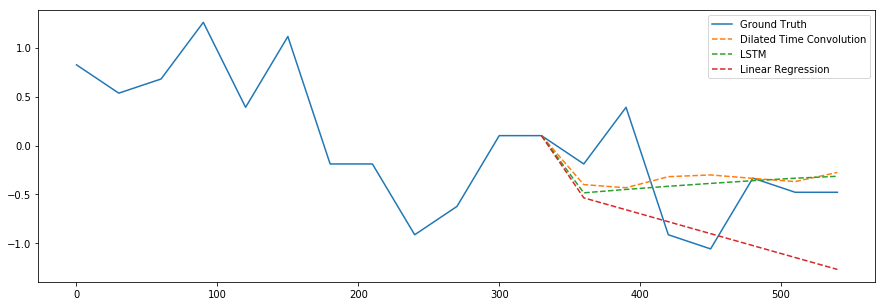

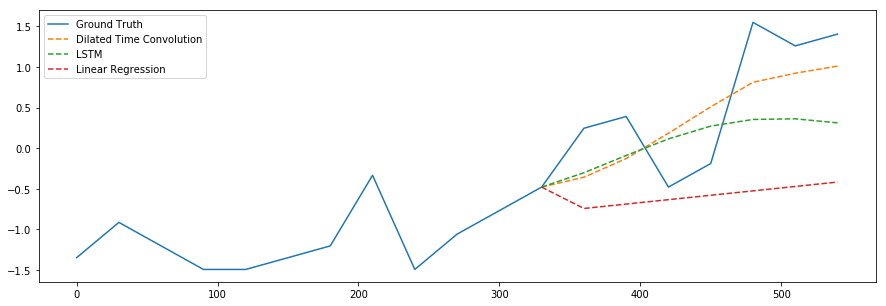

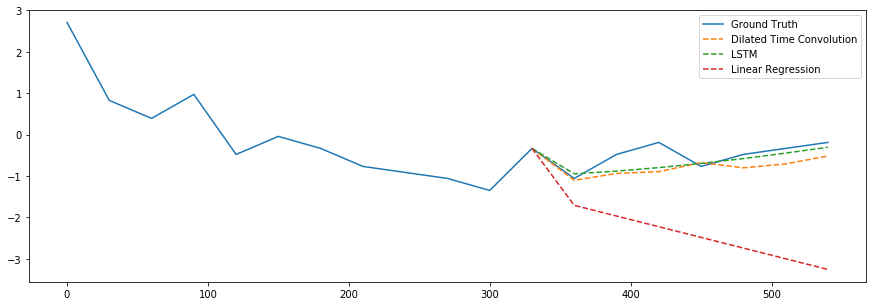

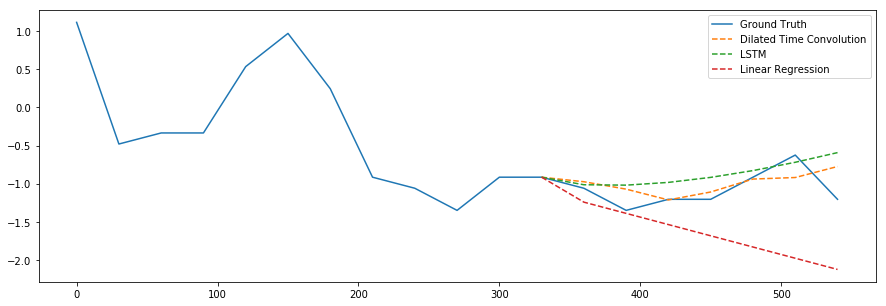

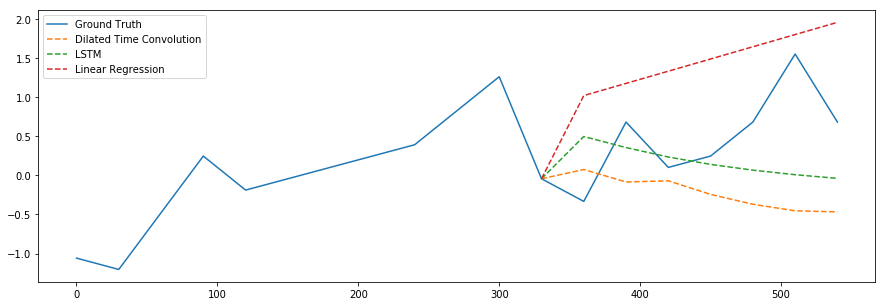

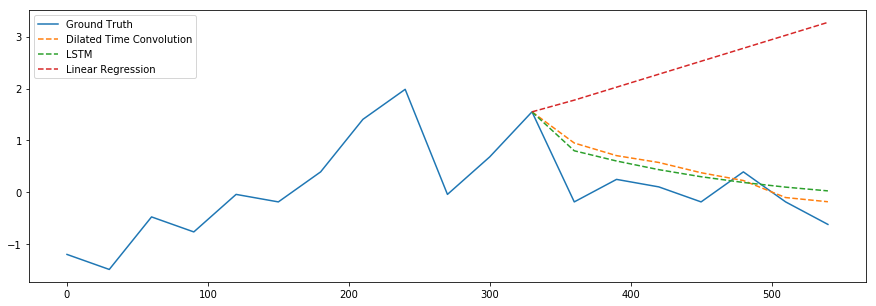

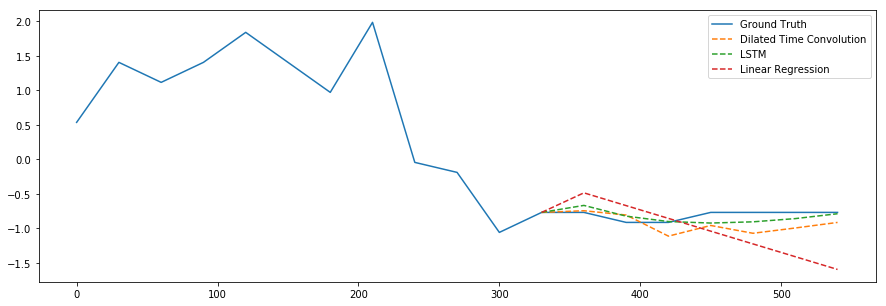

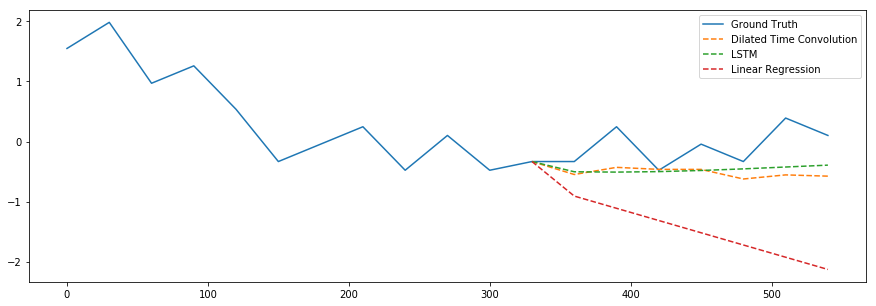

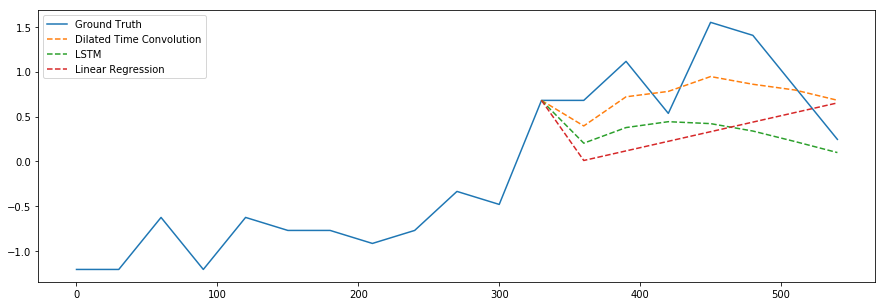

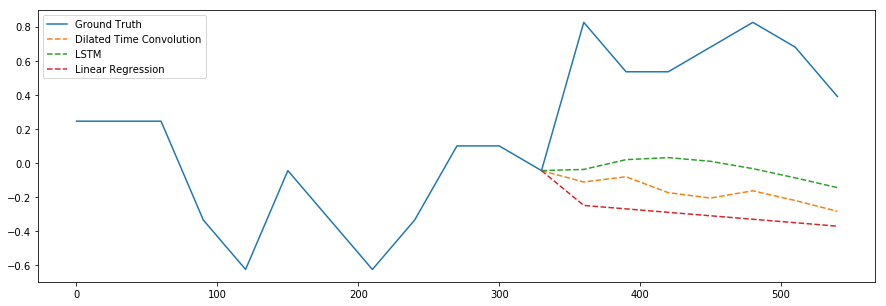

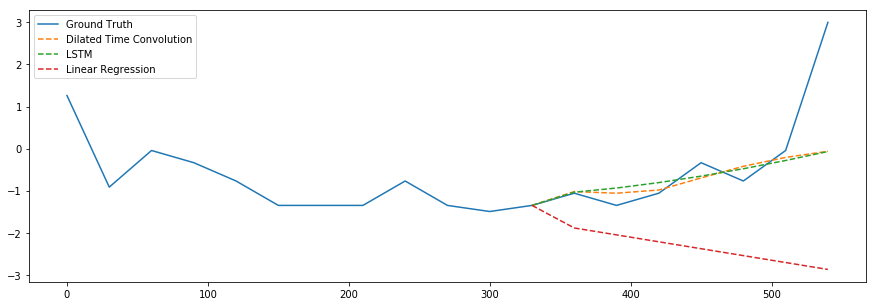

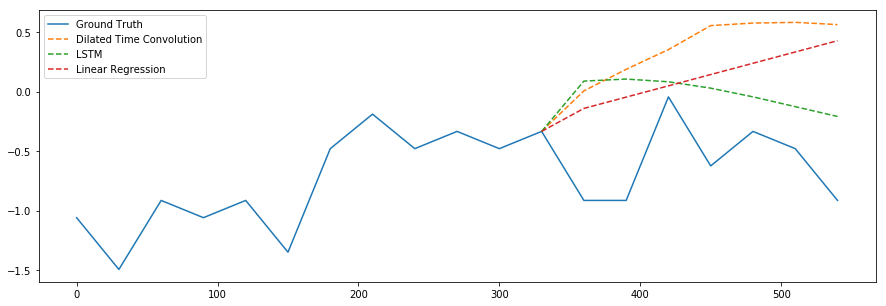

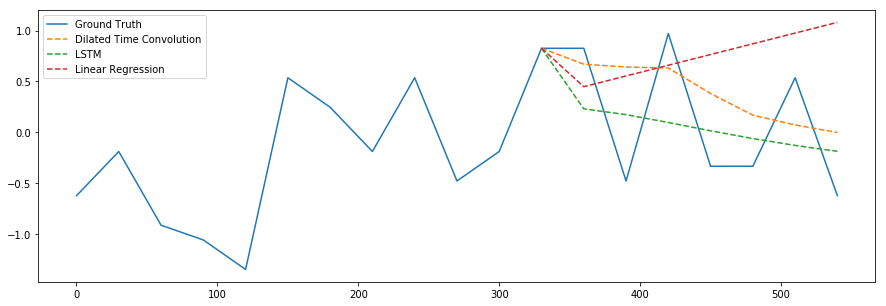

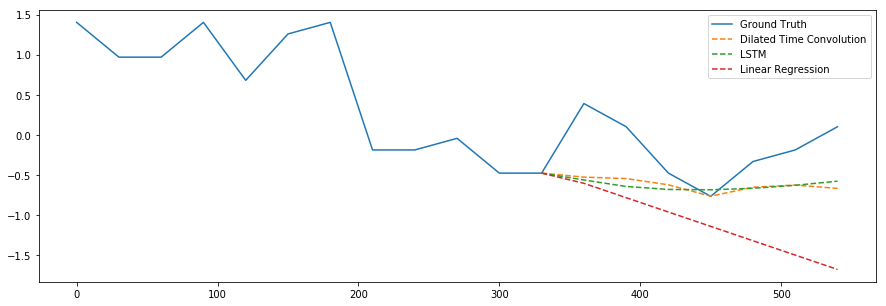

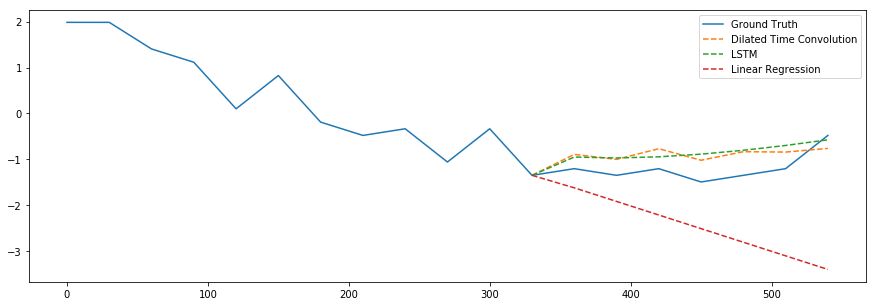

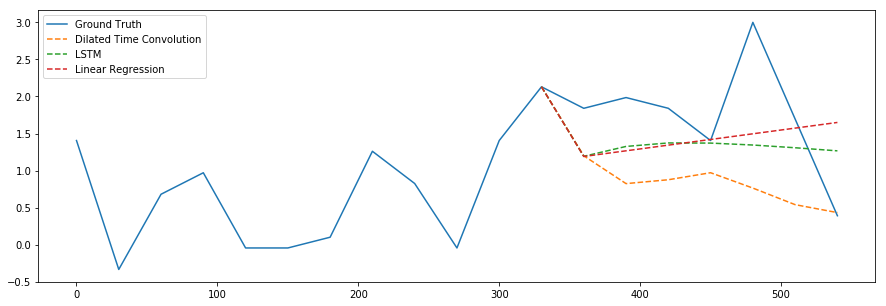

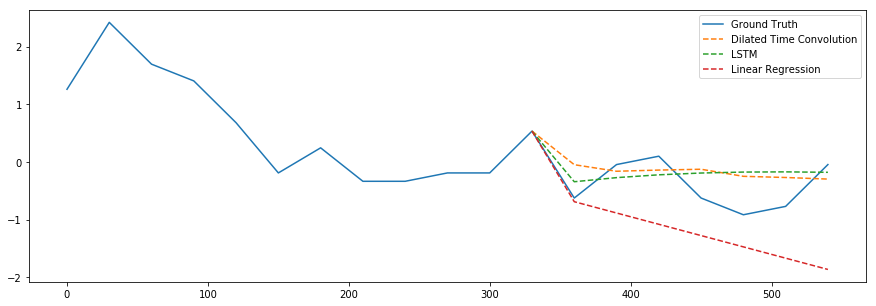

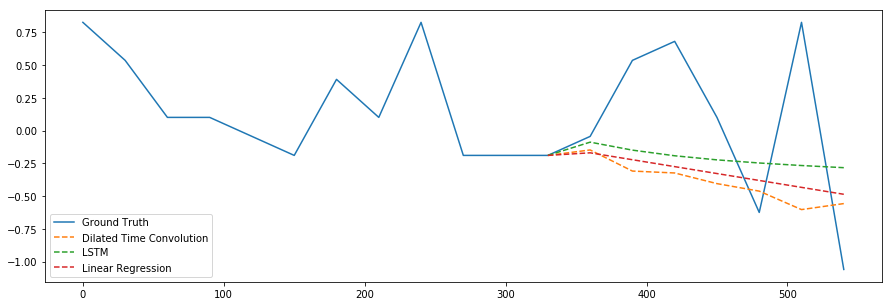

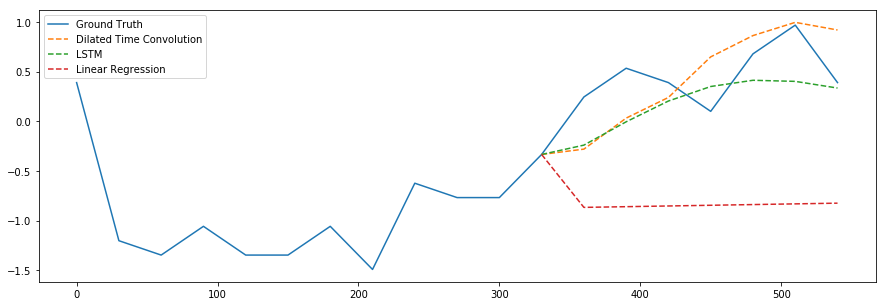

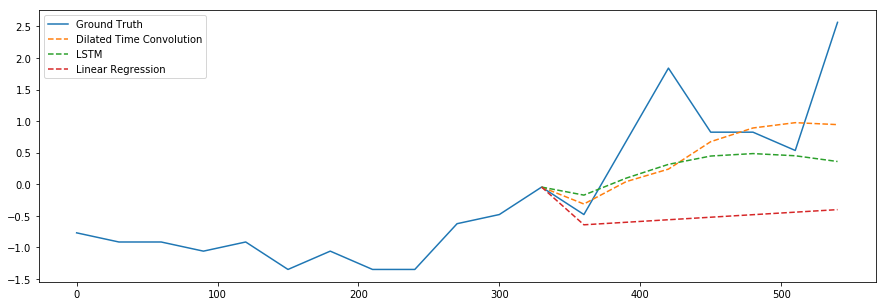

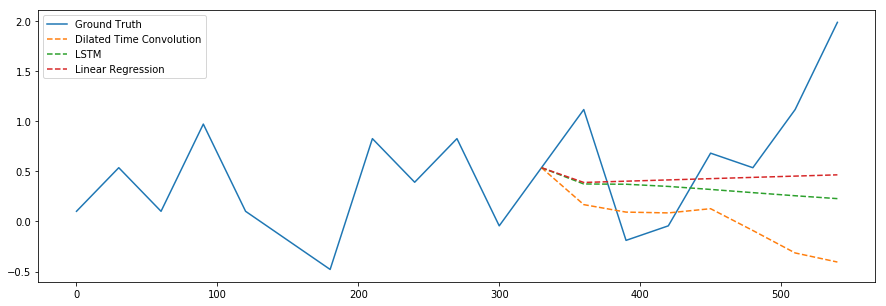

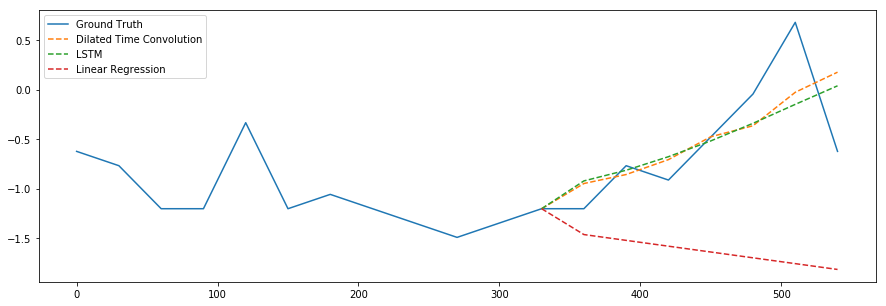

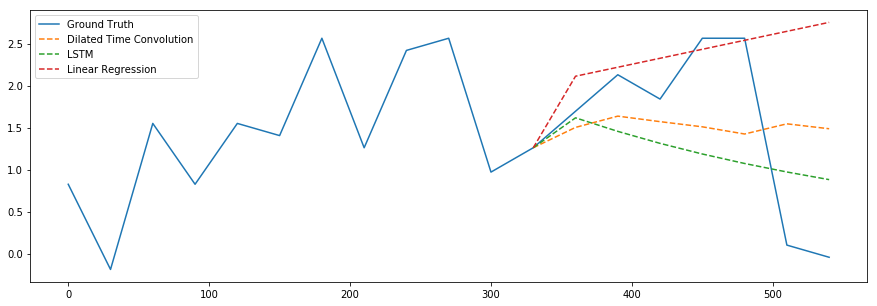

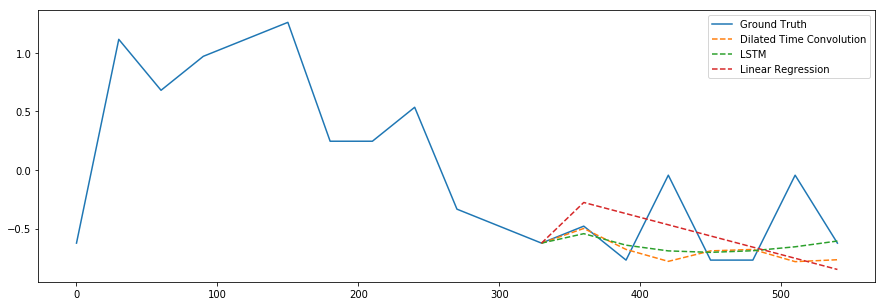

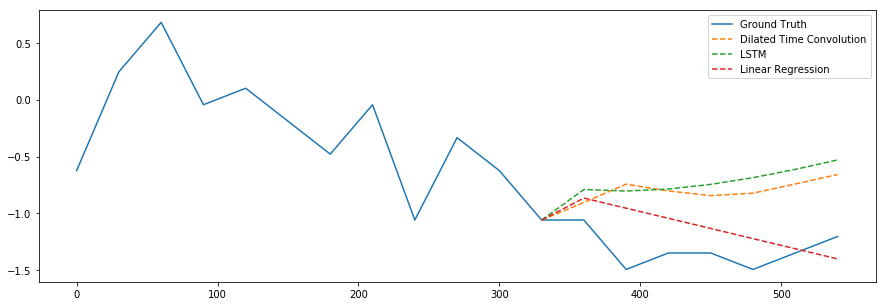

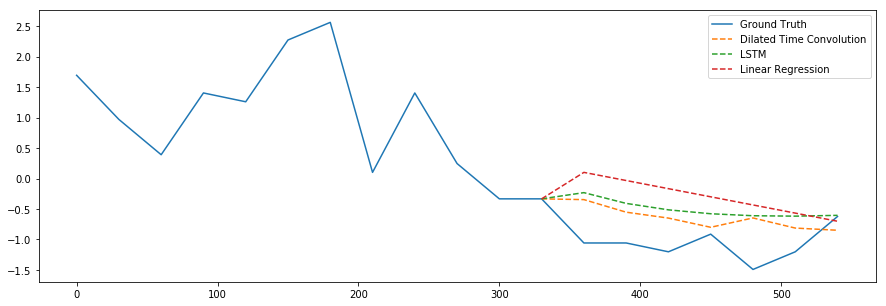

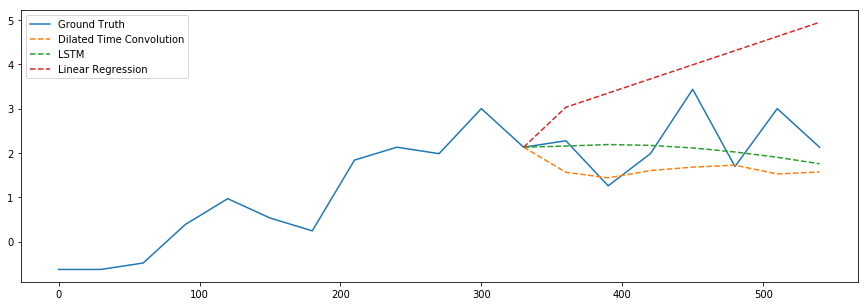

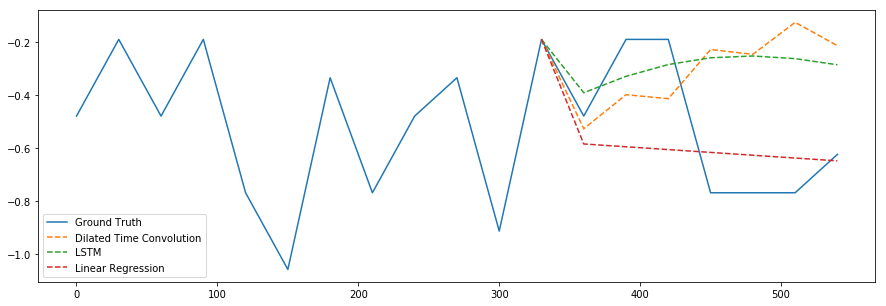

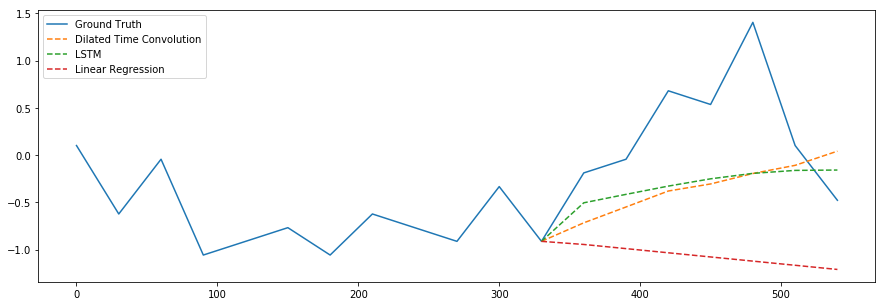

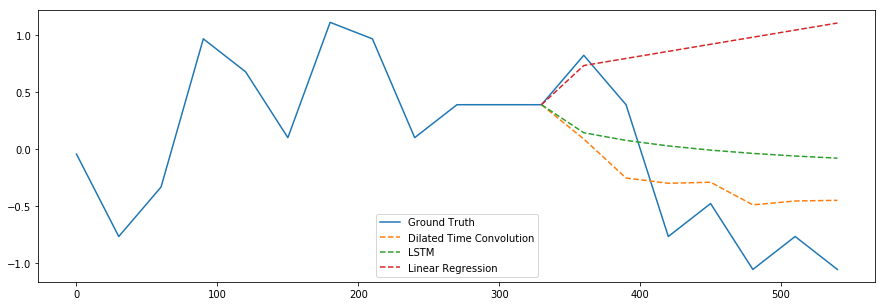

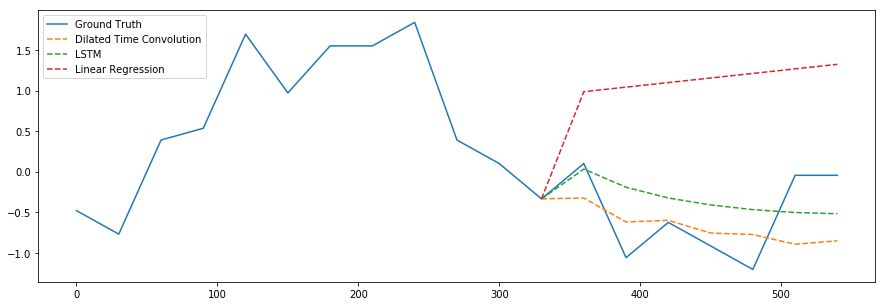

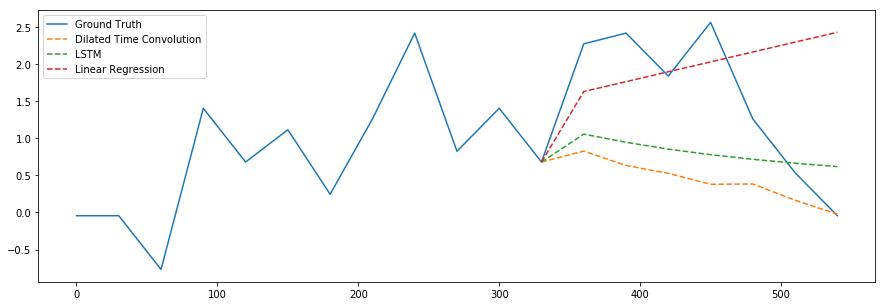

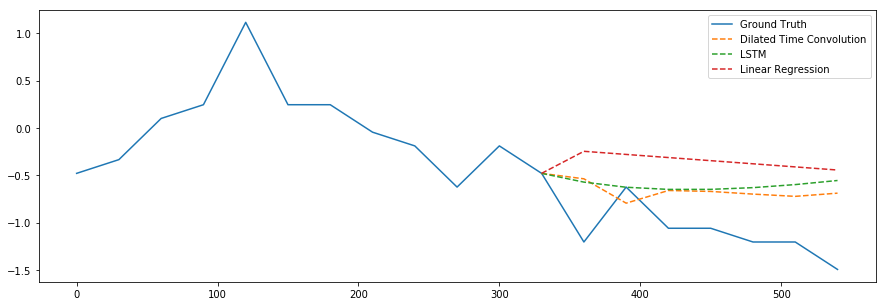

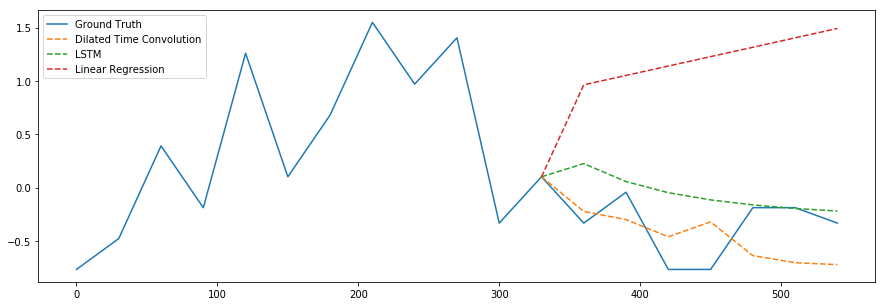

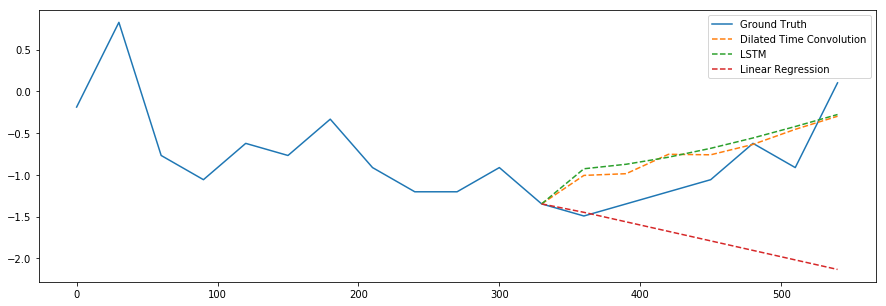

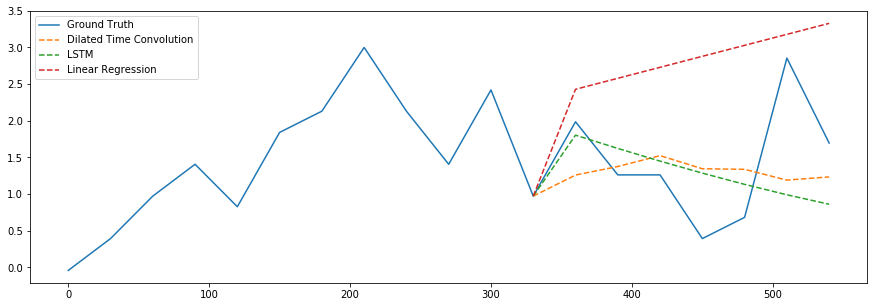

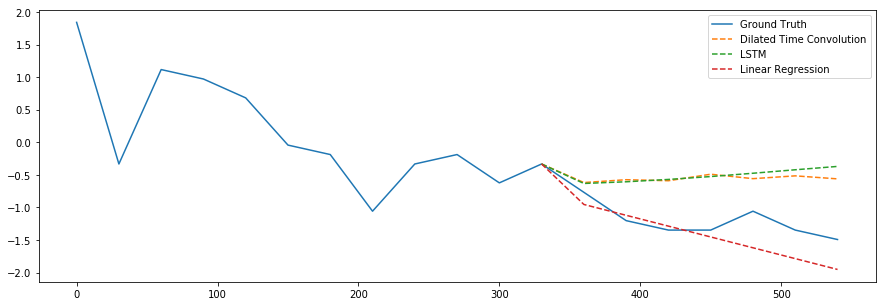

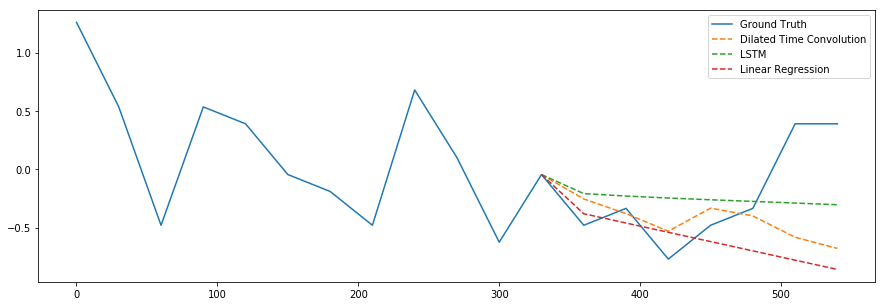

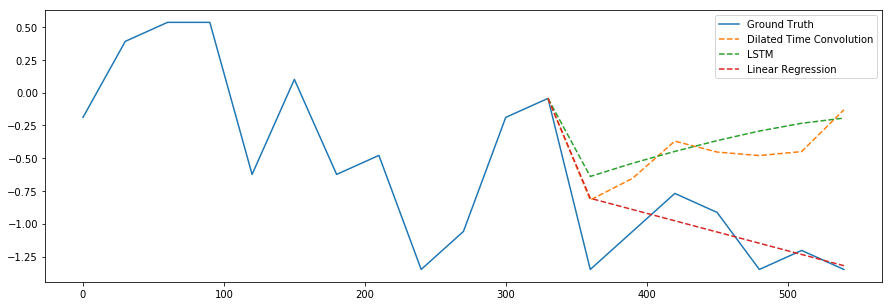

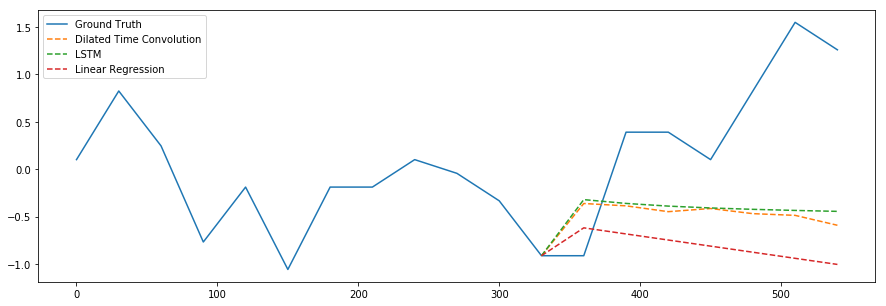

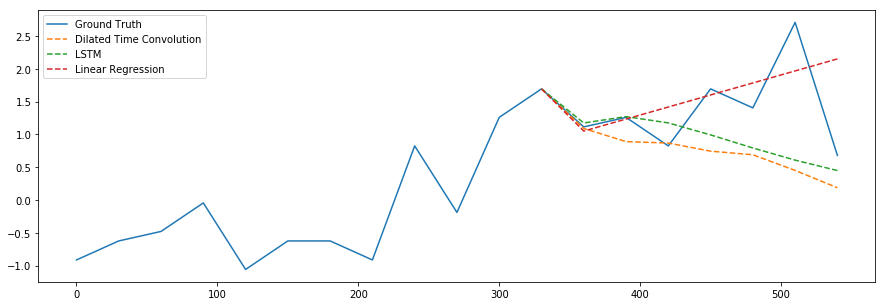

In [47]:
for i in range(0,len(test_inputs)):
    
    real = np.array(list(test_inputs[i])+list(sample['targets'].squeeze(2)[i]))
    predicted = np.array(list(np.array(test_inputs[i][-1:]))+list(pred[i]))

    plt.figure(figsize=(15,5))
    plt.plot(np.arange(12+future)*interval,real,label = 'Ground Truth')
    
    plt.plot(np.arange(11,12+future)*interval,predicted,linestyle='dashed',label = 'Dilated Time Convolution')
    
    plt.plot(np.arange(11,12+future)*interval,np.array(list(test_inputs[i][-1:])+list(pred1[:, -future:][i])),linestyle='dashed',label = 'LSTM')
    plt.plot(np.arange(11,12+future)*interval,np.array(list(test_inputs[i][-1:])+list(pred2[i])),linestyle='dashed',label = 'Linear Regression')
    
    
    plt.legend()

## all nodes mean

In [27]:
losses = []
#nodes = [4,5]
nodes = list(x.columns)[94:]


scaler = None
x2 = (x - x.mean())/x.std()

for node in nodes:


    train_ds = DataLoaderSpecific(x2[node],seqs[:split],transform = scaler, test_num = future)
    train_dl = data.DataLoader(train_ds,batch_size = 25,shuffle=True,num_workers = 4)

    test_ds = DataLoaderSpecific(x2[node],seqs[split:],transform = scaler,test_num = future)
    test_dl = data.DataLoader(test_ds,batch_size = 50,shuffle=False,num_workers = 4)

    tconv = TConvDilated()
    tconv.double()
    criterion = nn.MSELoss(reduction='sum')

    optimizer = torch.optim.Adam(tconv.parameters(), lr = 10e-4)


    tconv.train()   
    test_loss = 0

    for e in range(30):

        train_loss = 0

        for sample in train_dl:



            inputs = sample['x'].squeeze(2).to(device)
            targets = sample['targets'].squeeze(2)[:,0].to(device)


            optimizer.zero_grad()
            out = tconv(inputs.unsqueeze(1))


            loss = criterion(out, targets.unsqueeze(1))

            #print(loss.item())

            loss.backward()

            optimizer.step()
            train_loss += loss.item()

        #print('Loss for epoch {} ---> {}'.format(e,train_loss/train_ds.__len__()))



    with torch.no_grad():

        tconv.eval()
        test_loss = 0

        for sample in test_dl:

            test_inputs = sample['x'].squeeze(2).to(device)
            #test_targets = sample['targets'].squeeze(2)[:,0].to(device)

            #out = tconv(test_inputs.unsqueeze(1))

            test_targets = sample['targets'].squeeze(2).to(device)
            pred = test_inputs.unsqueeze(1)
            for _ in range(7):
                pred = torch.cat((pred, tconv(pred).unsqueeze(2)),2)[:,:,-12:]



            loss = criterion(pred[:,:,-future:], test_targets.unsqueeze(1))


            test_loss += loss.item()

        print('\t Dilated Time convolution Test loss:', test_loss/(test_ds.__len__()*future))

        tconv.train()


        losses.append([node,(test_loss/(test_ds.__len__()*future))])
        np.save('losses2.npy',losses)

         #save final results
        file = open("losses2.txt","a")
        file.write("{},{}\n".format(node,(test_loss/(test_ds.__len__()*future))))
        file.close()

	 Dilated Time convolution Test loss: 0.9948542373368229
	 Dilated Time convolution Test loss: 0.8057903770490131
	 Dilated Time convolution Test loss: 0.4655635436200409
	 Dilated Time convolution Test loss: 1.056967118809368
	 Dilated Time convolution Test loss: 0.8570666373690209
	 Dilated Time convolution Test loss: 1.1398633655944284
	 Dilated Time convolution Test loss: 0.6211789087176741
	 Dilated Time convolution Test loss: 0.414411413583843
	 Dilated Time convolution Test loss: 0.3481737624084117
	 Dilated Time convolution Test loss: 0.998650332794926
	 Dilated Time convolution Test loss: 1.035311309621842
	 Dilated Time convolution Test loss: 0.9565107219255993
	 Dilated Time convolution Test loss: 1.3061725308428138
	 Dilated Time convolution Test loss: 1.1254220117985336
	 Dilated Time convolution Test loss: 0.8963812960481257
	 Dilated Time convolution Test loss: 0.9762647432541289
	 Dilated Time convolution Test loss: 1.012615747343641
	 Dilated Time convolution Test loss

	 Dilated Time convolution Test loss: 1.1171348219169928
	 Dilated Time convolution Test loss: 1.0229398169426303
	 Dilated Time convolution Test loss: 0.3669275735581633
	 Dilated Time convolution Test loss: 0.5802448318679686
	 Dilated Time convolution Test loss: 1.005836544589391
	 Dilated Time convolution Test loss: 1.0138209904484567
	 Dilated Time convolution Test loss: 1.0180846694122754
	 Dilated Time convolution Test loss: 0.9844084193557315
	 Dilated Time convolution Test loss: 0.7790639817462182
	 Dilated Time convolution Test loss: 0.6388733233210405
	 Dilated Time convolution Test loss: 0.5692116073430094


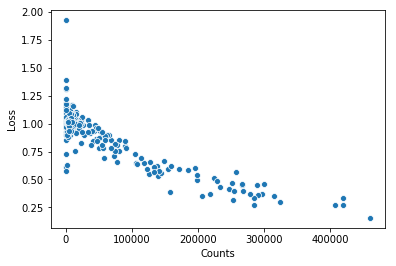

In [29]:
import seaborn as sns

corr = pd.read_csv('losses2.txt',header=None)
corr.columns = ['loc','Loss']

occ = pd.read_csv('data/finalGps.csv',index_col=0)
merged = pd.merge(corr, occ, how='inner', on=None, left_on='loc', right_on='LocationID',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

#plt.scatter(merged.Counts,merged.Loss)
#sns.regplot(merged.Counts,merged.Loss,order=2)
sns.scatterplot(merged.Counts,merged.Loss)

In [30]:
merged.corr()

,loc,Loss,LocationID,lat,lng,Counts
loc,1.000000,-0.204716,1.000000,0.116741,-0.054855,0.143378
Loss,-0.204716,1.000000,-0.204716,-0.060475,0.297729,-0.878696
LocationID,1.000000,-0.204716,1.000000,0.116741,-0.054855,0.143378
lat,0.116741,-0.060475,0.116741,1.000000,0.326469,0.044210
lng,-0.054855,0.297729,-0.054855,0.326469,1.000000,-0.316183
Counts,0.143378,-0.878696,0.143378,0.044210,-0.316183,1.000000


In [31]:
merged.Loss.mean()

0.895910818853875